In [1]:
# hide
import matplotlib.patches
from matplotlib.patches import Rectangle, Ellipse, FancyArrow, Arrow
import matplotlib.pyplot as plt
import numpy as np


class canvas:
    def __init__(self, figsize, pixsize):
        plt.figure(figsize=figsize)
        self.pixsize = pixsize
        self.ax = ax = plt.gca()
        #self.ax.set_frame_on(False)
        self.ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        self.ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 1)
    def get_ax(self):
        return self.ax
    def _normalize(self, p):
        return (p[0] / self.pixsize[0], p[1] /self.pixsize[1])
    def rect(self, p, width, height, label=None, label_color=None, **attr):
        sp = self._normalize(p)
        sw, sh = self._normalize((width,height))
        self.ax.add_patch(Rectangle(sp, sw, sh, **attr))
        if label:
            self.ax.text(sp[0] + sw/2, sp[1] + sh/2, label, color=label_color, ha="center", va="center")
    def ellipse(self, p, width, height, label=None, label_color=None, **attr):
        sp = self._normalize(p)
        sw, sh = self._normalize((width,height))
        self.ax.add_patch(Ellipse(sp, sw, sh, **attr))
        if label:
            self.ax.text(sp[0], sp[1], label, color=label_color, ha="center", va="center")
    def arrow(self, p, width, height, label=None, label_offset=(0,0), label_color=None, **attr):
        sp = self._normalize(p)
        sw, sh = self._normalize((width,height))
        self.ax.add_patch(FancyArrow(sp[0], sp[1], sw, sh, width=0.01, length_includes_head=True, **attr))
        dx, dy = self._normalize(label_offset)
        if label:
            self.ax.text(sp[0] + sw/2 + dx, sp[1] + sh/2 + dy, label, color=label_color, ha="center", va="center")
    def text(self, p, label, **attr):
        sp = self._normalize(p)
        self.ax.text(sp[0], sp[1], label, **attr)


# 4. モデルの評価とパラメータチューニング

## 4.1 機械学習のフロー

- 訓練セットとテストセットに分割する
- モデルを構築し、チューニングする
    - 訓練セットを訓練用データと検証用データに分割
    - 訓練用データで訓練したモデルを、検証用データで評価
    - 検証用データでの評価結果が良くなるように、モデルのハイパーパラメータを更新
- テストセットでモデルを評価

<img src="images/training-test.png" width="500"/>

機械学習の一般的な作業の流れ

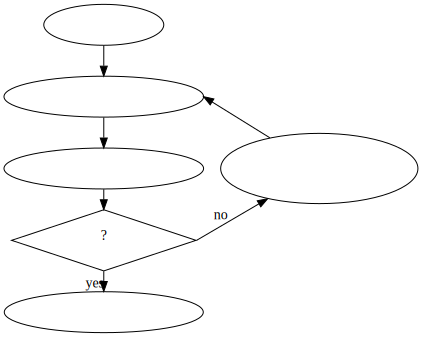

In [2]:
# hide
import graphviz

dot = graphviz.Digraph('training-flow', engine='neato')
dot.node('mc', 'モデル作成', pos="0,8!")
dot.node('tr', '訓練用データで訓連', pos="0,7!")
dot.node('hpt', 'ハイパーパラメータ\nチューニング', pos="3,6!")
dot.node('val', '検証用データで評価', pos="0,6!")
dot.node('div', '十分よいか?', shape='diamond', pos="0,5!")
dot.node('test', 'テストセットで評価', pos= "0,4!")
dot.edge('mc', 'tr')
dot.edge('tr', 'val')
dot.edge('hpt', 'test', style='invis')
dot.edge('val', 'div')
dot.edge('div:e', 'hpt', label='no')
dot.edge('hpt', 'tr:e', minlen = '1')
dot.edge('div', 'test', label='yes')
dot



#### 注意点
- テストセットは最後のモデル評価以外では使ってはいけない
- テストセットを使ってハイパーパラメータチューニングするのは**絶対に**禁止
    - しりたいのは未見のデータに対する性能。テストセットは未見データの代用
    - テストセットに対してチューニングすると、未見ではなくなるので意味がない

####  単純な分割の限界
訓練セットを訓練用データと検証用データに単純に分割すると
- データの量がたりなくなる
- 訓練用データに含まれているデータ点に対する評価がハイパーパラメータチューニングに反映されない


## 4.2 交差検証

訓練用データと検証用データの分割を何度も繰り返す。
- すべての訓連セットデータを用いてモデルを訓練し
- すべての訓連セットデータを用いてモデルを評価できる

#### k分割交差検証

- 訓練セットをk個に分割
- そのうちの一つを検証用とし、残りを訓練用に用いて評価
- これをk回繰り返し、平均値をスコアとして採用する

'5分割交差検証'

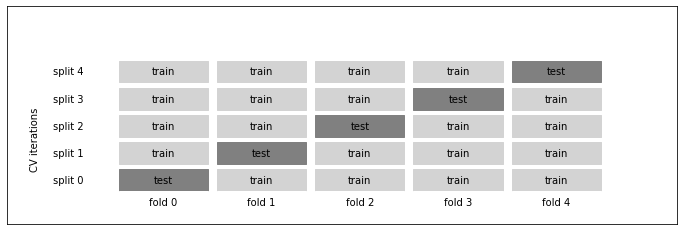

In [3]:
# hide
c = canvas((12,4), (600, 200))

off = (100, 30)
r_size = (80, 20)
r_gap = (8, 5)
div = 5
for x in range(div):
    for y in range(div):
        color = "gray" if x == y else "lightgray"
        label = "test" if x == y else "train"
        c.rect((off[0] + (r_size[0] + r_gap[0]) * x, off[1] + (r_size[1] + r_gap[1]) * y), r_size[0], r_size[1], label = label, color=color)

for x in range(div):
    c.rect((off[0] + (r_size[0] + r_gap[0]) * x, 10), r_size[0], r_size[1], label = "fold {}".format(x), color="w")

for y in range(div):
    c.rect((15, off[1] + (r_size[1] + r_gap[1]) * y), r_size[0], r_size[1], label = "split {}".format(y), color="w")

c.text((20, 50), "CV iterations", rotation=90)
"5分割交差検証"

乳癌データセットと、ロジスティック回帰を用いた実行例

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

# データセットの読み込み
cancer = load_breast_cancer()
ss = StandardScaler()
# 訓連・テスト データセットを分割
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 標準化
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

# X_train_s に対して交差検証
mdl = LogisticRegression()
scores = cross_val_score(mdl, X_train_s, y_train)
print("Scores: {}\nAverage: {}".format(scores, scores.mean()))


Scores: [0.98837209 0.98823529 0.95294118 1.         0.97647059]
Average: 0.9812038303693571


スコアには1から0.95 まで、5%もの幅があることがわかる。

#### 1つ抜き交差検証
- k分割交差検証の考え方を極限まで推し進めた方法
- k=データセットサイズ 
- 1サンプルのみを検証、残りすべてを訓練に使う
- これをサンプル数だけ繰り返す




In [5]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
mdl = LogisticRegression()
scores = cross_val_score(mdl, X_train_s, y_train, cv=loo)
print("Scores: {}\nAverage: {}".format(scores, scores.mean()))


Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

交差検証の問題点
- 訓練をk回くりかえすことになり、時間がかかる
- 訓練に長大な時間がかかるディープラーニング界隈ではあまり用いられない　

## 4.3 グリッドサーチ

- モデルの性能を向上させるには、ハイパーパラメータチューニングが必要
- 複数のハイパーパラメータがある場合、すべてのハイパーパラメータの候補値の組み合わせを尽くす必要がある
- グリッド格子状にパラメータを設定して最良の組み合わせを探索する
- 注意: グリッドサーチには、テストセットを用いず、検証用データを用いること

> **ハイパーパラメータ**  
> 学習モデルの学習対象となるパラメータ(重み)では**なく**、
> モデルそのもののパラメータのこと。通常のパラメータ特別するためにこう呼ぶ


In [6]:
from sklearn.svm import SVC
gammas = [0.001, 0.01, 0.1, 1, 10]
Cs = [0.001, 0.01, 0.1, 1, 10]

results = []
for gamma in gammas:
    inner = []
    for C in Cs:
        mdl = SVC(gamma=gamma, C=C)
        scores = cross_val_score(mdl, X_train_s, y_train)
        inner.append(scores.mean())
    results.append(inner)
results

[[0.6267578659370725,
  0.6267578659370725,
  0.690123119015048,
  0.9413679890560875,
  0.9741723666210671],
 [0.6267578659370725,
  0.6267578659370725,
  0.9414227086183311,
  0.9741723666210671,
  0.9858823529411765],
 [0.6267578659370725,
  0.6267578659370725,
  0.9390150478796169,
  0.9530232558139536,
  0.9389329685362519],
 [0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725,
  0.6314363885088918,
  0.6314363885088918],
 [0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725,
  0.6267578659370725]]

ヒートマップによる可視化
- 直感的な把握が可能
- ハイパーパラメータ2つの場合にしか使用できない

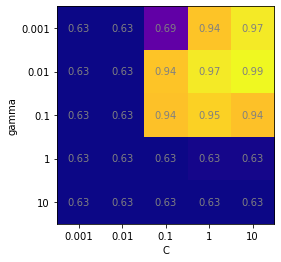

In [7]:
# hide
import matplotlib.pyplot as plt
import matplotlib.cm as cm

ax = plt.gca()
ax.imshow(results, cmap=cm.plasma)

ax.set_xticks(np.arange(len(Cs)), labels=Cs)
ax.set_yticks(np.arange(len(gammas)), labels=gammas)
ax.set_xlabel("C")
ax.set_ylabel("gamma")

for c in range(len(Cs)):
    for g in range(len(gammas)):
        ax.text(c, g, "{:0.2f}".format(results[g][c]), 
                ha="center", va="center", color="gray")

グリッドサーチは多用されるので専用のクラスが用意されている。Estimatorという枠組みで、モデルと同様に扱うことができる。

In [8]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(), {'C': Cs, 'gamma': gammas}, cv=5)

# モデルと同じように訓練する
grid_search.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]})

In [9]:
grid_search.best_params_

{'C': 10, 'gamma': 0.01}

In [10]:
grid_search.score(X_test_s, y_test)

0.9790209790209791

- 個々の訓練に長大な時間がかかる場合や、パラメータ空間が広大な場合にはグリッドサーチは現実的ではない。
- ディープラーニングでは、ベイズ最適化と呼ばれる手法を用いた最適化技法が用いられる。
   - 最小限の試行で最適なハイパーパラメータを効率よく求める

## 4.4 評価基準とスコア
### 4.4.1 混同行列 (Confusion Matrix)

予測と実際の陽性(Positive)、陰性(Negative)をマトリクス状にプロットしたもの
- 真陽性 TP True Positive    正しく陽性であると認識された
- 偽陰性 FN False Negative   本当は陽性だが誤って陰性だと判断されたもの
- 偽陽性 FP False Positive   本当は陰性だが誤って陽性だと判断されたもの
- 真偽性 TN True Negative    正しく陰性であると判断されたもの


| 実際\予測 |   陽   |  陰 |
|:-----:|:--------:|:------:|
| 陽| 真陽性 TP | 偽陰性 FN |
| 陰| 偽陽性 FP | 真偽性 TN |


#### 陽性と陰性
- 注目する観点によってどちらになるかが決まる。良いこと、悪いことというニュアンスはない。
- 例えば癌の診断であれば、良性、悪性のどちらを陽性にするかは、データ解析者が恣意的に決めることであって、
先験的に決定することではない。

#### 偽陰性と偽陽性
- 基本的にトレードオフの関係にある
    - どちらかを減らそうとすると、もう一方が増大する
    - 多くの場合パラメータを変更することで調整可能
- 一方だけをへらすのは非常に簡単
    - 常に陽性であると判定すれば偽陰性はなくなる
    - 常に陰性であると判定すれば偽陽性はなくなる
- 場合によって、どちらのほうが「より許容できるか」が異なる
- 例: 病気の診断で、病気であることを陽性とする場合
    - 病気が致命的で追加検査が侵食的でない場合: 偽陽性が好ましい\
    $\rightarrow$ 広くスクリーニングして、積極的に追加検査するべき
    - 病気が致命的でなく追加検査が侵食的である場合: 偽陰性が好ましい\
    $\rightarrow$ 誤って追加検査するよりは、病気を見逃したほうがトータルで負荷が少ない





### 4.4.2 精度とその限界

- 精度(Accuracy)

  正しく分類されたサンプル数の割合
  $$ 精度 = \frac{|TP|+|TN|}{|TP|+|TN|+|FP|+|FN|} $$

- 問題点: 偏りのあるデータに対する評価に適さない

  例: 晴天率が90%である地方で、常に晴天であると予測する - 精度 90% だが実は全く意味のないモデルになっている

| 実際\予測|  陽   |  陰 |
|:-----:|:--------:|:------:|
| 陽| TP = 90 | FN = 0|
| 陰| FP = 10 | TN = 0|



### 4.4.3 その他の指標
#### 適合率 (precision)
陽性であると予測されたのサンプルのうち、実際に陽性だった割合

$$ 適合率 = \frac{|TP|}{|TP|+|FP|} $$

#### 再現率 (recall)
実際に陽性のサンプルのうち、正しく陽性と予測された割合。

$$ 再現率 = \frac{|TP|}{|TP|+|FN|} $$

#### いずれも単独では十分ではない



#### f-値  
適合率と再現率をバランス良くまとめるために、調和平均をとったもの。

$$ f値 = 2 \times \frac{適合率 \times 再現率}{適合率 + 再現率} = \frac{2|TP|}{2|TP| + |FP| + |FN|} $$

### 4.4.4 誤差の評価 - MSE と MAE
誤差を単純に加算したのでは、+方向の誤差と-方向の誤差が打ち消し合うのでダメ

- MSE (Mean Squared Error) - 平均二乗誤差
$$ \frac{1}{n} \sum_{i=0}^{n}(\hat{y_i} - y_i)^{2}$$
- MAE (Mean absolute Error) - 平均絶対誤差
$$ \frac{1}{n} \sum_{i=0}^{n}|(\hat{y_i} - y_i)|$$

MSEは大きい誤差に対してより強くペナルティが効く。

## 4.5 データの前処理
- 特徴量によって値のレンジが大きく異る場合
    - 特徴量A が0-1、特徴量Bが0-100 の値を取るようなケース
- そのまま扱うと値のレンジの大きい特徴量が支配的になり、レンジの小さい特徴量が十分に反映されない
- レンジがだいたい同じになるようにスケール変換する必要がある

### 注意点
- スケール変換が必要ないアルゴリズムもある
    - 決定木ベースの手法
    - 適当な値で各特徴量空間を分割していくだけなので、レンジが異なっても全く影響を受けない
- スケール変換は分割後の訓連データに対して学習を行い、同じ変換手法を用いてテスト/検証データを変換する
    - スケール変換はある種の教師なし学習

### いくつかの前処理手法
- MinMaxScalar - 最大値を1、最小値を0になるように変換
- StandardScalar - 平均0、分散1になるように変換
- RobustScalar - 中央値と四分位数を用いて変換。外れ値を無視する
- Normalizer - 原点からの方向だけを維持して、超球面上に投射


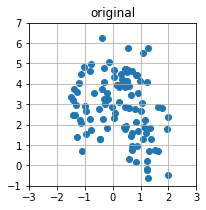

In [11]:
# hide
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
import matplotlib.pyplot as plt
import numpy as np
def plot(ax, x, label):
    ax.scatter(x[:,0], x[:,1])
    ax.set_title(label)
    ax.set_xticks(range(-3, 4))
    ax.set_yticks(range(-1, 8))
    ax.grid()
X, _ = make_blobs(random_state=0)
X *= np.array([0.5,1.0])
_, ax = plt.subplots(1,1, figsize=(3,3))
plot(ax, X, "original")

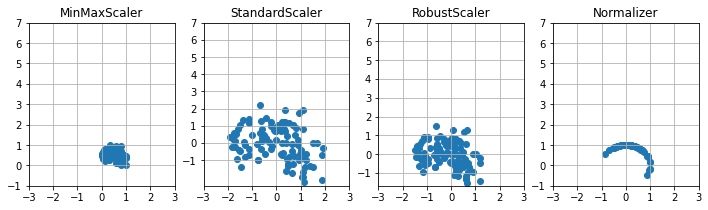

In [12]:
# hide
trans = [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()]
_, axes = plt.subplots(1, 4, figsize=(12,3))
for i, t in enumerate(trans):
    X_ = t.fit_transform(X)
    plot(axes[i], X_, t.__class__.__name__);

## 4.6 ケーススタディ: アンバランスデータの分類

- 陽性と偽性の数が極端に違う場合、モデルの評価が非常に難しい。

簡単なトイデータで考える
- 0 が 30
- 1 が 270

In [13]:
# hide
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def test_random():
    _, axes = plt.subplots(10,10, figsize=(18,15))
    for r in range(100):
        X, y = make_blobs(n_samples = [15, 15, 270], random_state=r)
        axes[r//10][r%10].scatter(X[:,0], X[:,1], c=y)
        axes[r//10][r%10].set_title(f"random_state={r}")

# test_random()       
#X, y = make_blobs(n_samples = [30, 270], random_state=59)
#plt.scatter(X[:,0], X[:,1], c=y)


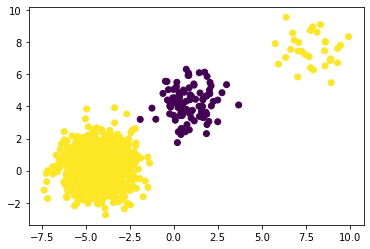

In [14]:
X, y = make_blobs(n_samples = [100, 870, 30], random_state=3)
y[y==2] = 1
plt.scatter(X[:,0], X[:,1], c=y)


これを線形分離すると正答率は90%になる。これは良い値なのかどうか。

In [15]:

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=3, train_size=0.4)
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
y_predict = lgr.predict(X_test)

accuracy_score(y_test, y_predict)

0.9016666666666666

一番多いクラスを探し、それを常に答えるモデルの成績は線形分離とあまりかわらない。

In [16]:
from sklearn.dummy import DummyClassifier
mst = DummyClassifier(strategy="most_frequent")
mst.fit(X_train, y_train)
y_predict = mst.predict(X_test)
accuracy_score(y_test, y_predict)

0.8916666666666667

正解ラベルの比率に応じてランダムに予測するものでも82.6%もでてしまう。

In [17]:
rnd = DummyClassifier(strategy="stratified")
rnd.fit(X_train, y_train)
y_predict = rnd.predict(X_test)
accuracy_score(y_test, y_predict)

0.825

線形分離のほうがベターなはずなのになぜこうなるのか?

→ 精度が評価基準として適切でないから。

前述した混同行列、precision, recall, f値で評価してみよう。

まずは混同行列をみてみよう。`confusion_matrix` 関数を用いる

In [18]:
from sklearn.metrics import confusion_matrix
mdls = [lgr, mst, rnd]
mdl_names = ["線形分離", "つねに0", "ランダム"]

for mdl, name in zip(mdls, mdl_names):
    print("{}\n{}\n".format(name, 
        confusion_matrix(y_test, mdl.predict(X_test))))

線形分離
[[ 24  41]
 [ 18 517]]

つねに0
[[  0  65]
 [  0 535]]

ランダム
[[  8  57]
 [ 37 498]]



- つねに0を返す分類器は左側の列に数字がなく、明らかに異常なことがわかる。
- ランダム分類器は、左下の偽陰性が明らかに多い

precision, recall, f1-score を見るには、`classification_report` を用いる。


In [19]:
from sklearn.metrics import classification_report, f1_score

for mdl, name in zip(mdls, mdl_names):
    print("{}\n{}".format(name, 
        classification_report(y_test, mdl.predict(X_test), zero_division=1)))


線形分離
              precision    recall  f1-score   support

           0       0.57      0.37      0.45        65
           1       0.93      0.97      0.95       535

    accuracy                           0.90       600
   macro avg       0.75      0.67      0.70       600
weighted avg       0.89      0.90      0.89       600

つねに0
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        65
           1       0.89      1.00      0.94       535

    accuracy                           0.89       600
   macro avg       0.95      0.50      0.47       600
weighted avg       0.90      0.89      0.84       600

ランダム
              precision    recall  f1-score   support

           0       0.07      0.05      0.06        65
           1       0.89      0.93      0.91       535

    accuracy                           0.83       600
   macro avg       0.48      0.49      0.48       600
weighted avg       0.80      0.83      0.82       600



- 上段は0を陽性としたスコア、下段は1を陽性としたときのスコア。
- これらの指標は どちらを陽性と考えるかで大きく値が異なる。
- 0を陽性とした場合のf1-score を比較すると優位性がわかる。

#### ROCカーブ

- 2クラス分類では連続値の出力を何らかのスレッショルドで区切って最終的な2値出力を得る
    - このスレッショルドを変更するとクラス分類器の性質を変えることができる。
    - 偽陽性と偽陰性のトレードオフをとることできる
- 偽陽性と偽陰性はどちらもエラーだが、これらのどちらが許容しやすいかは場合によってことなる
    - 癌の診断であれば、癌を見落とす(偽陰性)よりも、癌ではない場合に癌であると判断する(偽陽性)のほうが望ましい





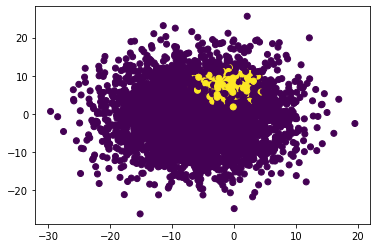

In [20]:
from sklearn.svm import SVC

X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], 
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

plt.scatter(X[:, 0], X[:, 1], c=y)


In [21]:
svc = SVC(gamma=.05).fit(X_train, y_train)

In [22]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1004
           1       0.64      0.67      0.66       121

    accuracy                           0.92      1125
   macro avg       0.80      0.81      0.81      1125
weighted avg       0.93      0.92      0.93      1125



In [23]:
y_predict_lower = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_predict_lower))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1004
           1       0.56      0.86      0.68       121

    accuracy                           0.91      1125
   macro avg       0.77      0.89      0.81      1125
weighted avg       0.94      0.91      0.92      1125



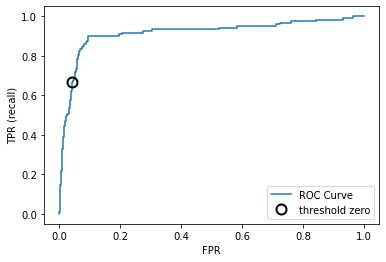

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# 0に最も近いスレッショルドを見つける
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
    label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

In [25]:
y_predict_lower = svc.decision_function(X_test) > -.8